In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.optimizers import Adam

# Data preparation

Helper functions

In [ ]:
def get_cards():
  """
    Set the values ​​of the dealer's and player's cards
  """
  dlr_opn_crd = np.random.randint(2, 11)
  dlr_crds = np.random.randint(2, 11) + dlr_opn_crd

  return np.random.randint(4, 21), \
         dlr_crds, \
         dlr_opn_crd

In [ ]:
def get_data_from_cards(cards):
  """
    Generate data for machine learning from values of cards
  """
  player_cards, dealer_cards, _ = cards

  player_cards += np.random.randint(2, 11)  # calculate next player card
  # according to it: what action should be taken

  while dealer_cards < 17:  # calculate to final dealer card
    dealer_cards += np.random.randint(2, 11)
  
  if dealer_cards > 21:  # dealer bust case: it was not necessary to take card
    return cards[0], cards[1], cards[2], -0.5, player_cards, dealer_cards
  
  if player_cards > 21:  # player bust case: mustn't take a card
    return cards[0], cards[1], cards[2], -1, player_cards, dealer_cards
  
  elif player_cards >= dealer_cards:  # win case: must take a card
    return cards[0], cards[1], cards[2], 1, player_cards, dealer_cards
  
  else:  # not bust case: should take a card
    return cards[0], cards[1], cards[2], 0.9, player_cards, dealer_cards

Generating data for training a neural network

In [ ]:
data_size = 30000 # @param training sample size

In [ ]:
data_raw = np.array([get_data_from_cards(get_cards()) for _ in range(data_size)])

print(data_raw[:10])  # raw data sampling

[[10.  12.   8.   0.9 13.  18. ]
 [20.   8.   2.  -0.5 29.  23. ]
 [ 7.   7.   3.   0.9 11.  17. ]
 [ 8.  16.   9.  -0.5 11.  26. ]
 [ 4.  15.  10.   0.9  8.  21. ]
 [11.   5.   2.  -0.5 17.  22. ]
 [ 7.  11.   5.   0.9  9.  21. ]
 [ 6.   6.   3.   0.9 11.  19. ]
 [ 9.   6.   2.   1.  19.  18. ]
 [15.  12.   8.  -1.  22.  19. ]]


In [ ]:
X = data_raw[:, (0, 2)]  # input data: player's card sum, dealer's open card
Y = data_raw[:, 3]  # output data: action, taken by neural network (-1: stand, +1: hit)

print(X[:10], Y[:10], sep='\n\n')

[[10.  8.]
 [20.  2.]
 [ 7.  3.]
 [ 8.  9.]
 [ 4. 10.]
 [11.  2.]
 [ 7.  5.]
 [ 6.  3.]
 [ 9.  2.]
 [15.  8.]]

[ 0.9 -0.5  0.9 -0.5  0.9 -0.5  0.9  0.9  1.  -1. ]


# Creating a nn model

In [ ]:
model = Sequential([
          InputLayer((2,)),             # input layer : [player's card sum, dealer's open card]
          Dense(32, activation='relu'), # middle layer: 32 neurons - relu activation
          Dense(1, activation='tanh')   # output layer: from -1 to 1 - nn action
])

In [ ]:
model.compile(
    optimizer=Adam(0.001),
    loss='mean_squared_error',
    metrics=['accuracy']
)

Training the nn model

In [ ]:
model.fit(X, Y, batch_size=32, epochs=25, verbose=0)

# Using neural network

Simple example

In [ ]:
print(model.predict([[18, 11]]))  # player's card sum: 18, dealer's open card: 11(ace)

[[-0.23529074]]


More helper functions

In [ ]:
def boolprint(bll, msg):  # print message if condition is True
  if bll:
    print(msg)

In [ ]:
def play_blackjack(nn_model, bet=0, balance=1, show=True):
  """
    The neural network plays 
    1 game of blackjack with an automated dealer
  """
  player, dealer, dealer_open = get_cards()  # distribution of cards

  boolprint(bll=show, msg=f'Player: {player}, Dealer open: {dealer_open}') 

  if player == 21:       # BlackJack case
    if dealer_open < 10: 
      isBlackJack = 1
    else:
      isBlackJack = 0
  else:
    isBlackJack = -1

  # while nn takes cards, their values ​​are added to the player's sum
  while nn_model.predict([[player, dealer_open]]) >= 0 and player < 21:
      player += np.random.randint(2, 11)
      boolprint(bll=show, msg=f'Player: {player}, Dealer open: {dealer_open}')

  boolprint(bll=show, msg='----')  # dealer starts to take cards

  boolprint(bll=show, msg=f'Dealer: {dealer}')

  # doesn't stop until dealer have 17 - rules
  while dealer < 17:
      dealer += np.random.randint(2, 11)
      boolprint(bll=show, msg=f'Dealer: {dealer}')

  boolprint(bll=show, msg='----')  # results

  if isBlackJack == 1:  # blackjack 3:2
    boolprint(bll=show, msg=f'Player wins - BlackJack 3:2\nCards: {player, dealer, dealer_open}')
    res = (1, player, dealer, dealer_open, balance + 1.5*bet, bet)
  
  elif isBlackJack == 0:# blackjack 1:1
    boolprint(bll=show, msg=f'Player wins - BlackJack 1:1\nCards: {player, dealer, dealer_open}')
    res = (1, player, dealer, dealer_open, balance + 1.0*bet, bet)
  
  elif dealer > 21:     # dealer busts
    boolprint(bll=show, msg=f'Player wins\nCards: {player, dealer, dealer_open}')
    res = (1, player, dealer, dealer_open, balance + 1.0*bet, bet)
  
  elif player > 21:     # player busts
    boolprint(bll=show, msg=f'Dealer wins\nCards: {player, dealer, dealer_open}')
    res = (-1, player, dealer, dealer_open, balance - 1.0*bet, bet)
  
  elif dealer > player: # dealer's cards > player's cards
    boolprint(bll=show, msg=f'Dealer wins\nCards: {player, dealer, dealer_open}')
    res = (-1, player, dealer, dealer_open, balance - 1.0*bet, bet)
  
  elif dealer == player:# dealer's cards = player's cards
    boolprint(bll=show, msg=f'Draw\nCards: {player, dealer, dealer_open}')
    res = (0, player, dealer, dealer_open, balance, bet)
  
  elif player > dealer: # dealer's cards < player's cards
    boolprint(bll=show, msg=f'Player wins\nCards: {player, dealer, dealer_open}')
    res = (1, player, dealer, dealer_open, balance + 1.0*bet, bet)
  
  boolprint(bll=show, msg='\n-*---*-\n')  # end of game

  return res

One game of blackjack

In [ ]:
play_blackjack(model, 20, 100, show=True)

Игрок: 15, Откр.дилера: 4
Игрок: 23, Откр.дилера: 4
----
Дилер: 11
Дилер: 18
----
Победа дилера(казино)
Карты: (23, 18, 4)

-*---*-



(-1, 23, 18, 4, 80.0, 20)

More test games

In [ ]:
games = 500  # @param number of test games

bal = 10000  # @param start balance

bet = 200    # @param bet

In [ ]:
his = []  # history of games results

for i in range(games):  # plays |games| games
  game = play_blackjack(model, bet, bal, show=False)  # plays 1 game

  his.append(game) # add result
  bal = game[-2]

his = np.array(his, dtype=int)
print(his[:5])

[[   -1    16    17     7  9800   200]
 [    1    17    24     8 10000   200]
 [    1    18    17     2 10200   200]
 [    1    21    20     3 10400   200]
 [    1    21    17     7 10600   200]]


Statistics

In [ ]:
print('Final balance:', bal)

print()

print('Percentage of defeats:', round(np.sum(his[:, 0] == -1) / games * 100, 1), '%')
print('Percentage of wins   :', round(np.sum(his[:, 0] == 1) / games * 100, 1), '%')
print('Percentage of draws  :', round(np.sum(his[:, 0] == 0) / games * 100, 1), '%')

Конечный  баланс: 22800.0

Процент поражений: 38.2 %
Процент побед:     51.0 %
Процент ничей:     10.8 %


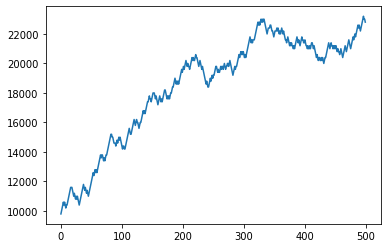

In [ ]:
plt.plot(his[:, -2])  # balance plot